# Autoencoder for the Kolmogorov Flow

In this session, you will need to use what you learned in the previous notebooks to develop a particular neural network called an autoencoder.
The Kolmogorov flow is governed by the following equation:
\begin{align}
    \nabla \cdot \mathbf{u} &= 0\\
   \partial_t \mathbf{u} + \mathbf{u} \cdot \nabla \mathbf{u} &= -\nabla p + \frac{1}{Re} \Delta \mathbf{u} + \mathbf{f}
\end{align}
where $\mathbf{u} = (u,v)$ is the flow velocity over the domain $(x,y)\in \Omega = [0,2\pi]\times[0,2\pi]$ with periodic boundary conditions and $p$ is the pressure field.
In the Kolmogorov flow, the forcing term, $\mathbf{f}$ is $\mathbf{f} = (sin(k_fy),0)$.

The Kolmogorov flow admits a laminar solution $u= \frac{Re}{k_f^2} \sin(k_fy)$, $v=0$ which is unstable for large enough $Re$ and $k_f$.

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1. Import librairies

In [27]:
import numpy as np
# import tensorflow as tf

# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

# from datetime import datetime
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.optimizers import Adam 



# 2. Read dataset

In [28]:
hf = h5py.File('/content/drive/MyDrive/Capstone-Flow/Colab/Code/Kolmogorov/Kolmogorov_Re40.0_T20000_DT01.h5','r')
Nx = 24
Nu = 1
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))

vort_all = np.zeros((Nx,Nx,len(t),Nu))#my code
vort_all[:,:,:,0] = np.array(hf.get('vort_refined'))#my code

# u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
vort_all = np.transpose(vort_all,[2,0,1,3]) #my code
hf.close()
print(u_all.shape)
print(vort_all.shape)#my code

# normalize data
u_min = np.amin(u_all[:,:,:,0])
u_max = np.amax(u_all[:,:,:,0])
u_all[:,:,:,0] = (u_all[:,:,:,0] - u_min) / (u_max - u_min)

vort_min = np.amin(vort_all[:,:,:,0]) #my code
vort_max = np.amax(vort_all[:,:,:,0]) #my code
vort_all[:,:,:,0] = (vort_all[:,:,:,0] - vort_min) / (vort_max - vort_min) #my code

if Nu==2:
    v_min = np.amin(u_all[:,:,:,1])
    v_max = np.amax(u_all[:,:,:,1])
    u_all[:,:,:,1] = (u_all[:,:,:,1] - v_min) / (v_max - v_min)


(4000, 24, 24, 1)
(4000, 24, 24, 1)


(4000, 1)


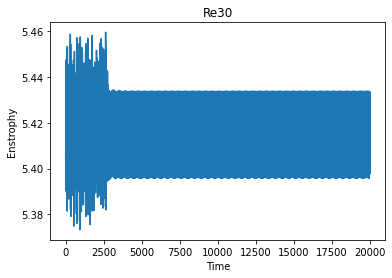

In [ ]:
dx = 2*np.pi/23. #0.1 #my code
dy = 2.*np.pi/23. #0.1 #my code

omega = np.sum(np.sum((vort_all ** 2), 2), 1) #my code
omega = omega * dx * dy * 0.5 #my code
print(omega.shape) #my code

plt.plot(t, omega) #my code
plt.title("Re30")
plt.xlabel("Time")
plt.ylabel("Enstrophy")
plt.savefig("Re30.png")
plt.show() #my code
from google.colab import files
# files.download("Re30.png") 


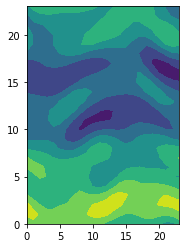

In [29]:
# visualization of the dataset
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all[50,:,:,0])
# ax2 = fig.add_subplot(122)
# ax2.contourf(u_all[0,:,:,1])

# 3. Prepare dataset

In [ ]:
val_ratio = int(np.round(0.75*len(u_all)))
test_ratio = int(np.round(0.95*len(u_all)))

u_train = u_all[:val_ratio,:,:,:].astype('float32')
u_val = u_all[val_ratio:test_ratio,:,:,:].astype('float32')
u_test = u_all[test_ratio:,:,:,:].astype('float32')
#del u_all


# 4. Define the network

In [ ]:
input_img = Input(shape=(Nx,Nx,Nu))

nb_layer = 0
act = 'tanh'
dim = 64

x = Conv2D(dim * 8,(3,3), padding='same', activation=act)(input_img)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(dim * 4,(3,3), padding='same', activation=act)(x)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(dim * 2,(3,3), padding='same', activation=act)(x)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(dim,(3,3), padding='same', activation=act)(x)
encoded = MaxPool2D((3,3), padding='same')(x)

x = Conv2DTranspose(dim,(3,3), padding='same', activation=act)(encoded)
x = UpSampling2D((3,3))(x)
x = Conv2DTranspose(dim * 2,(3,3), padding='same', activation=act)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(dim * 4,(3,3), padding='same', activation=act)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(dim * 8,(3,3), padding='same', activation=act)(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2DTranspose(Nu,(3,3), activation='linear', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img,decoded)
encoder = tf.keras.models.Model(input_img,encoded)

# definition of the decoder
encoded_input = Input(shape=(1,1,encoded.shape[3]))
deco = autoencoder.layers[-7](encoded_input) # we re-use the same layers as the ones of the autoencoder
for i in range(6):
    deco = autoencoder.layers[-6+i](deco)

decoder = tf.keras.models.Model(encoded_input,deco)

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 24, 24, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 512)       5120      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 12, 12, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 256)       1179904   
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 6, 6, 128)         295

# 5. Training the Network
We use the difference between the network output and the real image to calculate or cost/loss function. As an optimizier we choose the AdamOptimizer and tell it which function value to minimize

In [ ]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0001),loss='mse')

In [ ]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
nb_epochs = 1000
batch_size = 20
hist = autoencoder.fit(u_train, u_train, epochs=nb_epochs, batch_size=batch_size,
                shuffle=True,validation_data=(u_test, u_test),
                       verbose=1,
                       callbacks=[model_checkpoint_callback,early_stop_callback])

Epoch 1/1000
150/150 [==============================] - 7s 40ms/step - loss: 0.0192 - val_loss: 0.0051
Epoch 2/1000
150/150 [==============================] - 6s 38ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/1000
150/150 [==============================] - 6s 38ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/1000
150/150 [==============================] - 6s 38ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/1000
150/150 [==============================] - 5s 37ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/1000
150/150 [==============================] - 6s 38ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/1000
150/150 [==============================] - 6s 38ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/1000
150/150 [==============================] - 6s 38ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/1000
150/150 [==============================] - 6s 38ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/1000
150/150 [==============================] - 6s 38ms/step - l

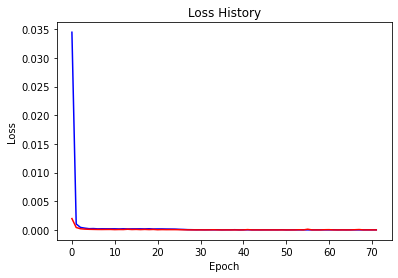

In [ ]:
loss_history = hist.history['loss']
val_history = hist.history['val_loss']
%matplotlib inline
plt.plot(loss_history,'b')
plt.plot(val_history,'r')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 6. Visualization of some prediction cases

(1, 24, 24, 1)


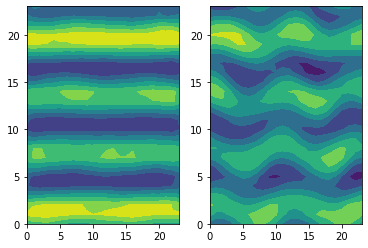

In [ ]:
y_nn = autoencoder.predict(u_test[0:1,:,:,:])
print(y_nn.shape)
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(y_nn[0,:,:,0])
ax = fig.add_subplot(122)
ax.contourf(u_test[0,:,:,0])
